<a href="https://colab.research.google.com/github/tyler-turnpike/tip-regression/blob/main/Tips_regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/tips (data for regression problem).csv")


In [ ]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [ ]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [ ]:
df.columns

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')

In [ ]:
import sklearn as sk

In [ ]:
df['sex'].replace(['Female','Male'],[0,1],inplace=True)
df['smoker'].replace(['No','Yes'],[0,1],inplace=True)
df['time'].replace(['Dinner','Lunch'],[0,1],inplace=True)

<ipython-input-9-0f7215e9f9bc>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sex'].replace(['Female','Male'],[0,1],inplace=True)
<ipython-input-9-0f7215e9f9bc>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'].replace(['Female','Male'],[0,1],inplace=True)
<ipython-input-9-0f7215e9f9b

In [ ]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
df.drop(labels=['tip'], axis=1),
df['tip'],
test_size=0.2,
random_state=0)

In [ ]:
X_train['day'].unique()

array(['Sun', 'Thur', 'Sat', 'Fri'], dtype=object)

In [ ]:
X_train['day'].value_counts().sort_values(ascending=False).head(5)

,count
day,
Sat,69
Sun,61
Thur,52
Fri,13


In [ ]:
top_5 = [tips for tips in X_train['day'].value_counts().sort_values(
ascending=False).head(5).index]

In [ ]:
for category in top_5:
    X_train['day' + '_' + category] = np.where(X_train['day'] == category, 1, 0)
    X_test['day' + '_' + category] = np.where(X_test['day'] == category, 1, 0)
print(X_train[['day'] + ['day'+'_'+c for c in top_5]].head(10))


      day  day_Sat  day_Sun  day_Thur  day_Fri
7     Sun        0        1         0        0
83   Thur        0        0         1        0
176   Sun        0        1         0        0
106   Sat        1        0         0        0
156   Sun        0        1         0        0
178   Sun        0        1         0        0
97    Fri        0        0         0        1
116   Sun        0        1         0        0
33    Sat        1        0         0        0
122  Thur        0        0         1        0


In [ ]:
ohe_enc = OneHotEncoder(top_categories=5,
                        variables=['day'],
                        drop_last=False)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
model = smf.ols('tip ~ total_bill + size + day + time', data=df).fit()
residuals = model.resid
fitted_values = model.fittedvalues

n = len(fitted_values)
half_n = n // 2

# First half
subset1 = df.iloc[:half_n]
# Second half
subset2 = df.iloc[half_n:]

# Fit separate models for the two subsets
model1 = smf.ols('tip ~ total_bill + size + day + time', data=subset1).fit()
model2 = smf.ols('tip ~ total_bill + size + day + time', data=subset2).fit()

# Compare the models using an F-test
f_statistic = ((model1.ssr - model2.ssr) / (model1.df_resid - model2.df_resid)) / (model2.ssr / model2.df_resid)
p_value = 1 - stats.f.cdf(f_statistic, model1.df_resid - model2.df_resid, model2.df_resid)

# Output results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The models are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference between models.")

F-statistic: -52.771671276681865
P-value: 1.0
Fail to reject the null hypothesis: No significant difference between models.


In [ ]:
df['day'] = df['day'].astype('category')
df['time'] = df['time'].astype('category')

# Fit a linear regression model
model = smf.ols('tip ~ total_bill + size + day + time', data=df).fit()  # Adjust formula as necessary

# Print the summary of the model
print(model.summary())

# Identify significant factors
significant_factors = model.pvalues[model.pvalues < 0.05].index.tolist()
print("Significant Factors Impacting Tip Amounts:")
print(significant_factors)

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     34.91
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           4.12e-30
Time:                        17:02:00   Log-Likelihood:                -347.69
No. Observations:                 244   AIC:                             709.4
Df Residuals:                     237   BIC:                             733.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7266      0.329      2.207      

In [ ]:
ohe_enc.fit(X_train)


OneHotEncoder(top_categories=5, variables=['day'])

In [ ]:
X_train_enc = ohe_enc.transform(X_train)
X_test_enc = ohe_enc.transform(X_test)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train_enc,y_train)

LinearRegression()

In [ ]:
reg.coef_

array([ 0.08561436, -0.00737383, -0.03190042,  0.45105997,  0.20932895,
       -0.00930718,  0.04250583, -0.15518531,  0.12198667, -0.00930718,
        0.04250583, -0.15518531,  0.12198667])

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr=LinearRegression()
lr.fit(X_train_enc,y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
y_pred=lr.predict(X_test_enc)

In [ ]:
print("MAE",mean_absolute_error(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

MAE 0.7080218832979823
MSE 0.89391952216096
R2 0.5545031052534937


In [ ]:
lr.coef_

array([ 0.08561436, -0.00737383, -0.03190042,  0.45105997,  0.20932895,
       -0.00930718,  0.04250583, -0.15518531,  0.12198667, -0.00930718,
        0.04250583, -0.15518531,  0.12198667])

<ipython-input-29-7eb992b72dfe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['day'] = data_subset['day'].astype('category').cat.codes  # Example for encoding 'day'
<ipython-input-29-7eb992b72dfe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['time'] = data_subset['time'].astype('category').cat.codes  # Example for encoding 'time'


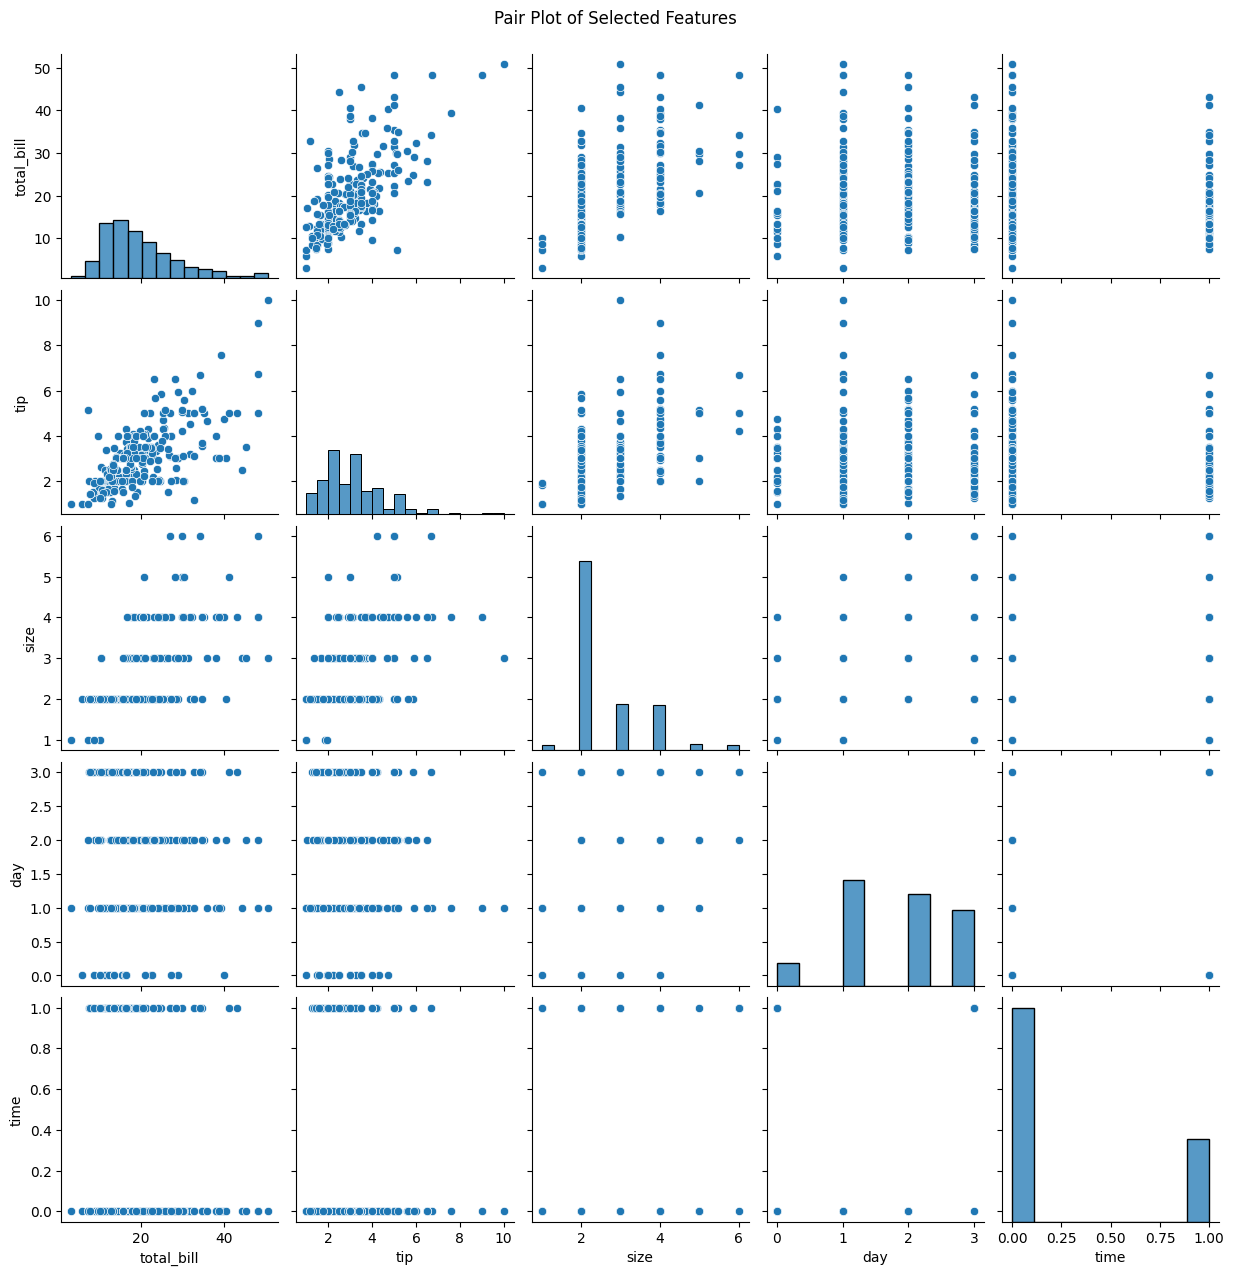

In [ ]:
features_to_plot = ['total_bill', 'tip', 'size', 'day', 'time']  # Example features
data_subset = df[features_to_plot]

data_subset['day'] = data_subset['day'].astype('category').cat.codes  # Example for encoding 'day'
data_subset['time'] = data_subset['time'].astype('category').cat.codes  # Example for encoding 'time'
sns.pairplot(data_subset)
plt.suptitle('Pair Plot of Selected Features', y=1.02)  # Adjust title position
plt.show()

In [ ]:
#Here we see that if we have failed to reject the null hypothesis using the rainbow test
#it shows that the model is likely linear

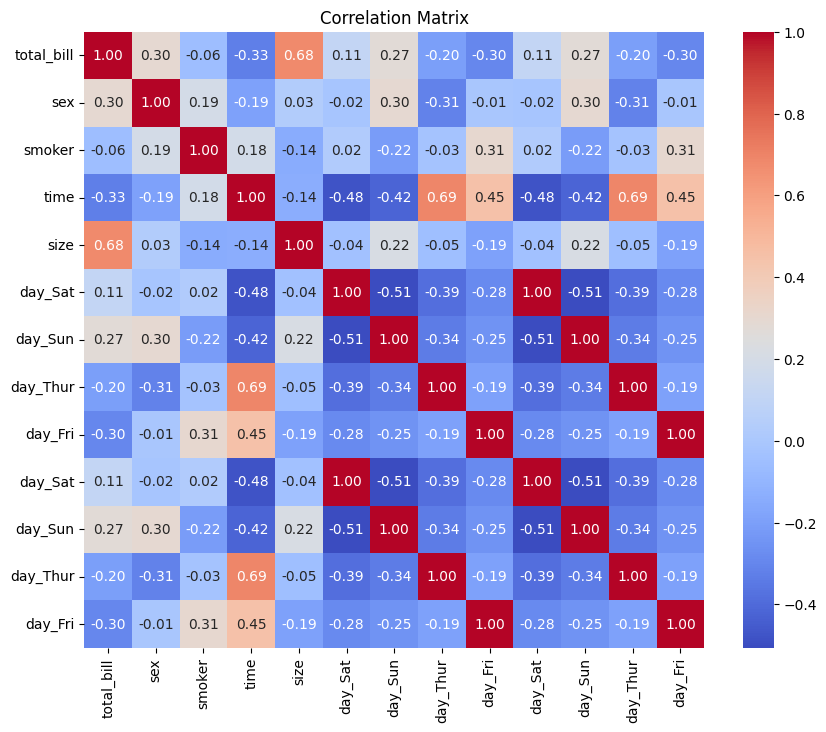

In [ ]:
correlation=X_test_enc.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
#to check the correlation between the variables

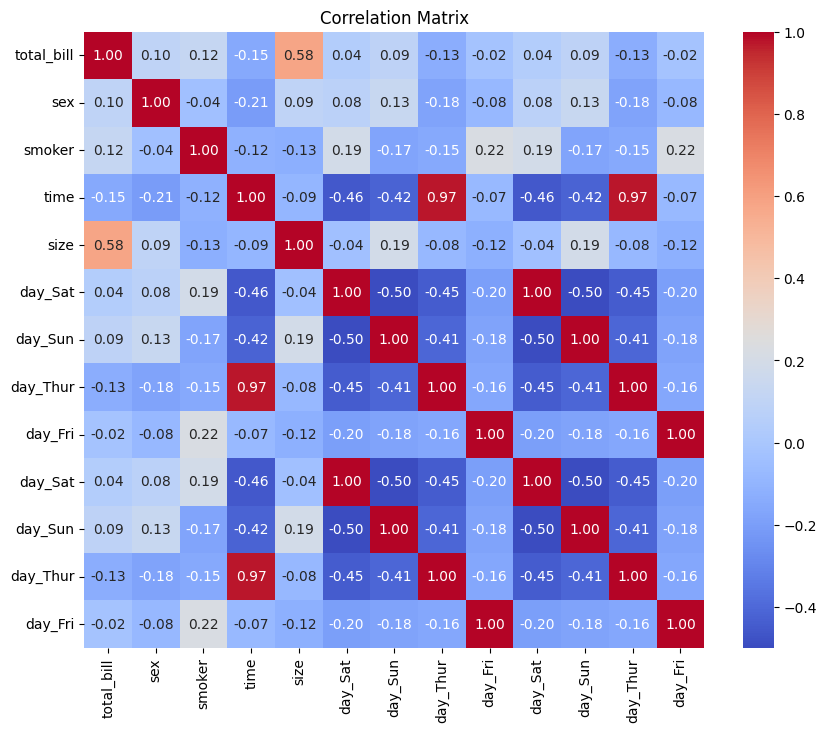

In [ ]:
correlation=X_train_enc.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
#we see that the correlation between day_Thur and time is very high so we need
#to drop day_Thur

In [ ]:
lr.intercept_

0.6518123853584172

In [ ]:
y_test

,tip
64,2.64
63,3.76
55,3.51
111,1.00
225,2.50
92,1.00
76,3.08
181,5.65
188,3.50
180,3.68


In [ ]:
y_pred

array([2.75976768, 2.99712626, 2.81673204, 1.4632311 , 3.12654885,
       1.77482578, 2.54679105, 3.11359077, 2.88681115, 4.50140326,
       3.18428659, 3.17091975, 2.3527022 , 2.29224593, 2.87517409,
       4.16944264, 1.92603957, 2.24308317, 2.3679374 , 3.30322842,
       3.79547836, 2.84290839, 2.5417152 , 2.43574813, 2.32853543,
       2.58333477, 2.76729999, 4.59978345, 3.73195325, 2.40199442,
       2.31295548, 2.27962689, 2.46828159, 1.92661159, 2.71399481,
       2.30185826, 2.71063603, 2.09555601, 5.60088215, 3.34295006,
       2.25147162, 2.27534617, 2.56519997, 4.33905752, 2.11239476,
       2.81768662, 2.60608807, 2.99566606, 2.72262204])

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_regression, k=10)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test_enc)
	return X_train_fs, X_test_fs, fs



# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train, X_test_enc)
# fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.708


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_enc)
X_test = scaler.transform(X_test_enc)

# Train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors Regression': KNeighborsRegressor(n_neighbors=5)
}

results = {}
predictions_dict={}
for name, model in models.items():
    model.fit(X_train_enc, y_train)
    predictions = model.predict(X_test_enc)
    predictions_dict[name] = predictions
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae=mean_absolute_error(y_test,predictions)
    results[name] = {'MSE': mse, 'R2': r2,'MAE':mae}

# Display results
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']}, R2 = {metrics['R2']},MAE={metrics['MAE']}")

Linear Regression: MSE = 0.89391952216096, R2 = 0.5545031052534937,MAE=0.7080218832979823
Ridge Regression: MSE = 0.8722188620347362, R2 = 0.5653179229865394,MAE=0.6874260668327831
Lasso Regression: MSE = 0.9049342002795262, R2 = 0.549013791308776,MAE=0.6901871312949666
Random Forest: MSE = 0.7629599765306123, R2 = 0.6197685676014881,MAE=0.7006551020408166
Gradient Boosting: MSE = 0.982335366793978, R2 = 0.5104398722063171,MAE=0.7180252787411804
Decision Tree: MSE = 2.241714285714286, R2 = -0.11718866009369244,MAE=1.1081632653061224
Support Vector Regression: MSE = 0.9078996677170068, R2 = 0.547535910468143,MAE=0.6456568097834573
K-Nearest Neighbors Regression: MSE = 1.1719971428571427, R2 = 0.4159193586773229,MAE=0.7894285714285715


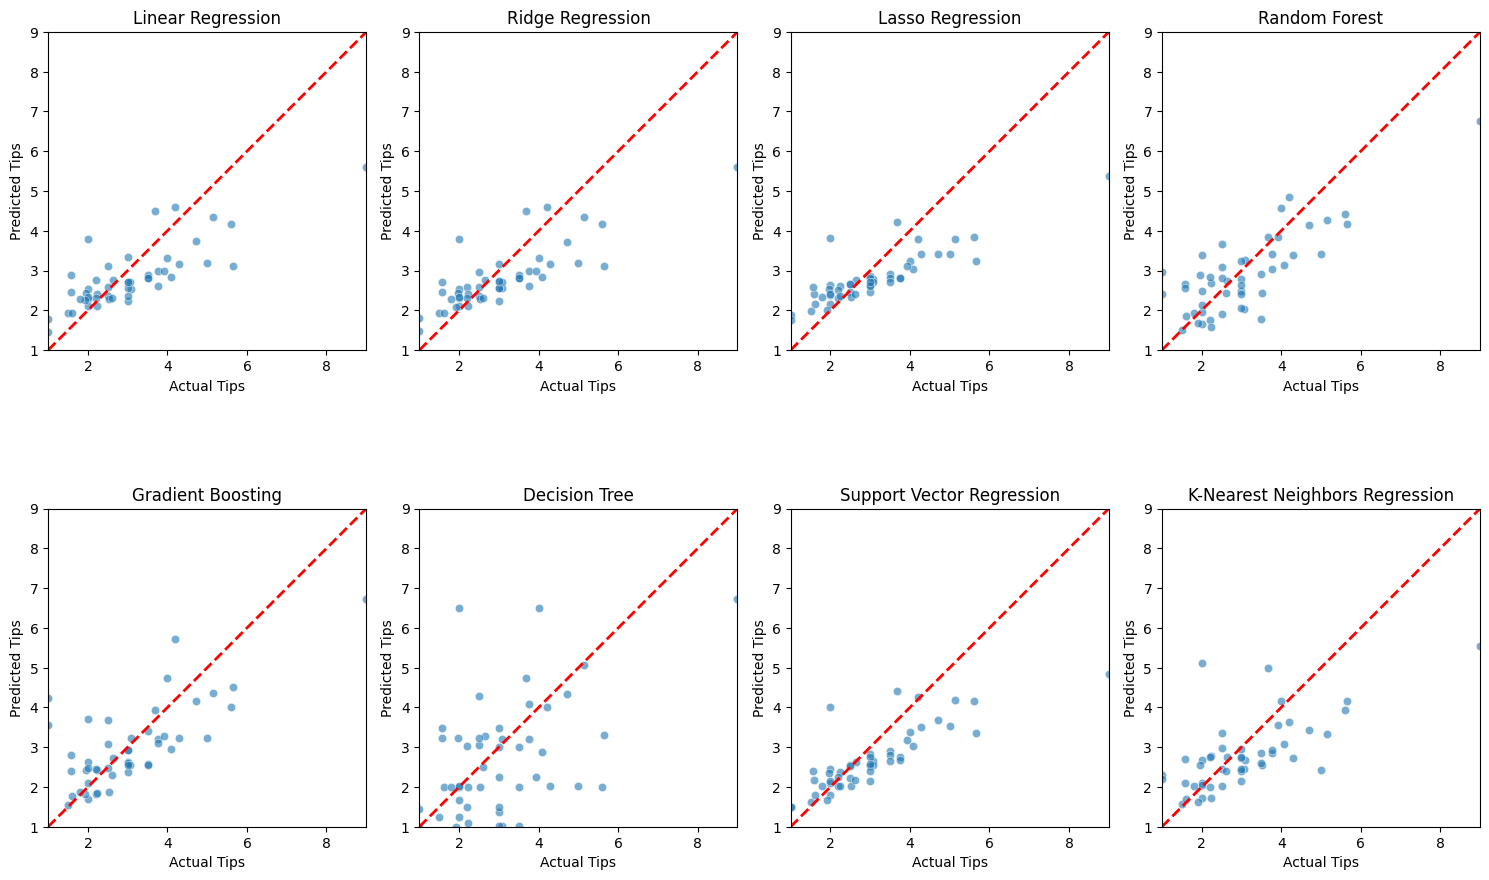

In [ ]:
plt.figure(figsize=(15, 10))

for i, (name, predictions) in enumerate(predictions_dict.items()):
    plt.subplot(2, 4, i + 1)
    sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal line
    plt.title(name)
    plt.xlabel('Actual Tips')
    plt.ylabel('Predicted Tips')
    plt.xlim(y_test.min(), y_test.max())
    plt.ylim(y_test.min(), y_test.max())
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

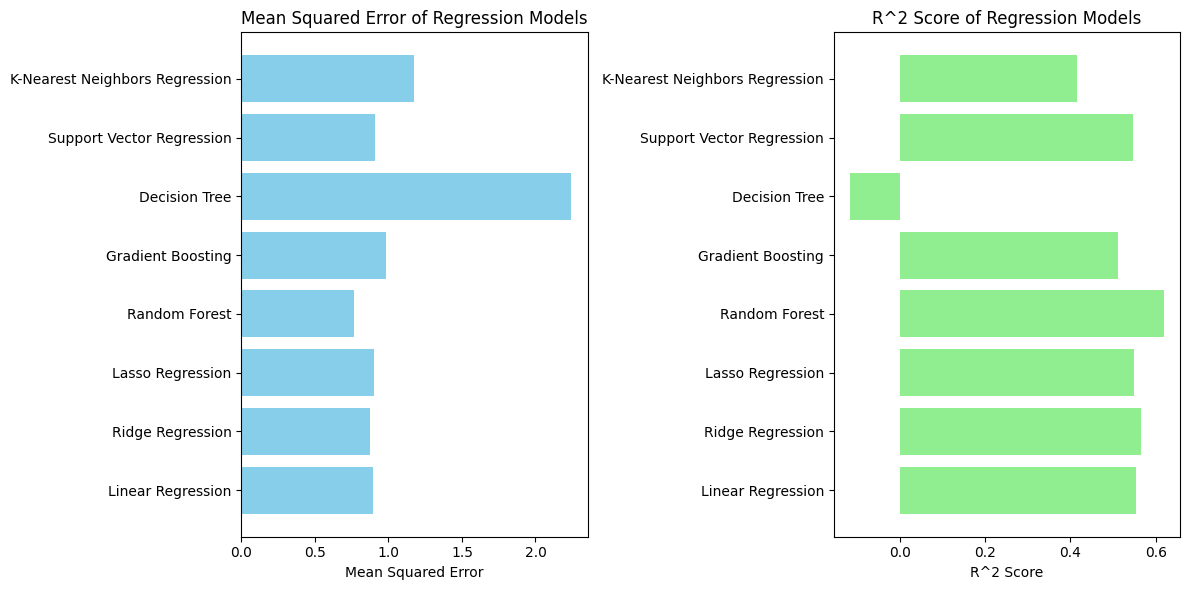

In [ ]:
model_names = list(results.keys())
mse_values = [metrics['MSE'] for metrics in results.values()]
r2_values = [metrics['R2'] for metrics in results.values()]

# Create a bar plot for MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(model_names, mse_values, color='skyblue')
plt.xlabel('Mean Squared Error')
plt.title('Mean Squared Error of Regression Models')

# Create a bar plot for R^2
plt.subplot(1, 2, 2)
plt.barh(model_names, r2_values, color='lightgreen')
plt.xlabel('R^2 Score')
plt.title('R^2 Score of Regression Models')

plt.tight_layout()
plt.show()